In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


=3


In [2]:
# Reviews.csv 내 568,454개 샘플 중 10만개만 추출
data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data/Reviews.csv", nrows=100000)
print('전체 샘플수:', len(data))

전체 샘플수: 100000


In [3]:
# 데이터 출력
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      100000 non-null  int64 
 1   ProductId               100000 non-null  object
 2   UserId                  100000 non-null  object
 3   ProfileName             99996 non-null   object
 4   HelpfulnessNumerator    100000 non-null  int64 
 5   HelpfulnessDenominator  100000 non-null  int64 
 6   Score                   100000 non-null  int64 
 7   Time                    100000 non-null  int64 
 8   Summary                 99998 non-null   object
 9   Text                    100000 non-null  object
dtypes: int64(5), object(5)
memory usage: 7.6+ MB


In [5]:
# 훈련에 사용할 summary열과 Text열만 별도 저장

data = data[['Summary','Text']]
data.head()

# #랜덤한 15개 샘플 출력
data.sample(15)

,Summary,Text
7625,DOA,Plant was dead on arrival and was mangled in i...
96402,Best. Mayo. Ever.,"Growing up in Alabama, this is the brand of ma..."
17104,Great buy!,This is the best cat food for my feral cats! T...
80012,Solid addition to the K-cup portfolio,"This is a nice smooth coffee, a part of the Ke..."
46123,yum,"This tea has a delicious flavor, fresh and lig..."
74176,"Kind of an interesting taste, but nothing I crave","I'm not a big fan of Taco Bell food, but I've ..."
92440,Great Coffee at a Great Price,I can not believe how rich and robust this cof...
2767,amish popcorn,worst popcorn ive ever bought. chewy not fluf...
98653,"Good taste, all natural, very few ingredients",I'm a fan of Larabars and the peanut ones are ...
43262,Love this stuff,I first had this in a Latin restaurant and cha...


## 데이터 전처리(1) - 데이터 정리하기

### 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [6]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 88426
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 72348


In [7]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset= ['Text'], inplace=True)
print('전체 샘플 수:', len(data))

전체 샘플 수: 88426


In [8]:
## Null값 처리 : .isnull().sum()
print(data.isnull().sum()) # 데이터프레임에 Null값이 있는지 확인

Summary    1
Text       0
dtype: int64


In [9]:
## Null값 제거 : dropna()
data.dropna(axis=0, inplace=True)
print('전체 샘플 수:', len(data))

전체 샘플 수: 88425


### 텍스트 정규화와 불용어 제거
- 텍스트 정규화(text normaliztion): 같은 의미인데도 다른 표현으로 쓰여 다른 단어들로 인식되는 단어들을 미리 같은 표현으로 통일시켜주는 처리
- 정규화 사전 출처 : https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
- 불용어(stopword) : 텍스트에 자주 등장하나 자연어 처리를 할 때 실질적으로 별 도움이 되지 않는 단어. 이를 높이면 자연어 처리 성능을 높일 수 있다

In [10]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [11]:
# 불용어 처리 : NLTK에서 제공하는 불용어 리스트 참조해 샘플에서 불용어를 제거하자
print('불용어 개수:', len(stopwords.words('english'))) # NLTK에서 제공하는 불용어 개수
print(stopwords.words('english')) # NLTK의 불용어 목록

불용어 개수: 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so

In [12]:
# 불용어 제거, 대문자>소문자, html태그 제거, 특수문자 제거 등의 처리 수행
# 불용어 제거는 Text전처리에서만 호출, Summary에서는 호출 X (요약 결과문이 자연스러운 문장 되기 위해)

# 데이터 전처리 함수

def preprocess_sentece(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, 'lxml').text # html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        # 불용어가 아니면서, 글자가 1개 이상인 단어들로만 sentence를 재구성
             tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)

    # 불용어 미제거 (Summary)
    else:
        # 문장을 모두 쪼개어 글자수가 1인 단어만 제거하고 다시 문장으로 재구성
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [13]:
# 위에서 만든 함수에 문장을 적용해보자

temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'
print('text: ', preprocess_sentece(temp_text))
print('summary: ', preprocess_sentece(temp_summary, False)) # 불용어 제거 X

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary:  great way to start the day


In [14]:
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
clean_text = []

# [[YOUR CODE]]

clean_text = data['Text'].apply(preprocess_sentece).tolist()

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better', 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo', 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch', 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal', 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']


In [15]:
# Summary 컬럼에 대해 전처리. 불용어처리 = False

clean_summary = []

# [[YOUR CODE]]

clean_summary = data['Summary'].apply(preprocess_sentece, remove_stopwords=False).tolist()

print("Summary 전처리 후 결과: ", clean_summary[:5])

Summary 전처리 후 결과:  ['good quality dog food', 'not as advertised', 'delight says it all', 'cough medicine', 'great taffy']


In [16]:
# 텍스트 정제 후 다시 한 번 빈 샘플이 생겼는지 확인해보는 게 좋다 (정제과정에서 문장의 모든 단어가 사라지는 경우도 있으므로)

# 데이터들을 데이터프레임에 재저장
data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값('')을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [17]:
# Null 값이 생겼는지 확인해보자
data.isnull().sum() # 원래 단어 있었으나, 정제과정에서 모든 단어 제거된 샘플 70개

Summary    70
Text        0
dtype: int64

In [18]:
# Null값 제거하기
data.dropna(axis=0, inplace=True)
print('전체 샘플수:', (len(data)))

전체 샘플수: 88355


In [19]:
data.isnull().sum()

Summary    0
Text       0
dtype: int64

### 데이터 전처리하기 (2) 훈련데이터와 테스트 데이터 나누기
- 학습에 사용할 데이터 크기 결정
- 문장의 시작과 끝 표시

In [20]:
# 훈련에 사용할 샘플의 최대길이 정하자
# Text, Summary의 최소, 최대, 평균 길이를 구하고 길이 분포를 시각화

# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']] # 'Text' 컬럼의 각 행에 대해 단어수를 계산해 'text_len' 배열의 해당하는 인덱스에 저장
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트 최소 길이:{}'.format(np.min(text_len)))
print('텍스트 최대 길이:{}'.format(np.max(text_len)))
print('텍스트 평균 길이:{}'.format(np.mean(text_len)))
print('요약의 최소 길이:{}'.format(np.min(summary_len)))
print('요약의 최대 길이:{}'.format(np.max(summary_len)))
print('요약의 평균 길이:{}'.format(np.mean(summary_len)))

텍스트 최소 길이:2
텍스트 최대 길이:1235
텍스트 평균 길이:38.792428272310566
요약의 최소 길이:1
요약의 최대 길이:28
요약의 평균 길이:4.010729443721352


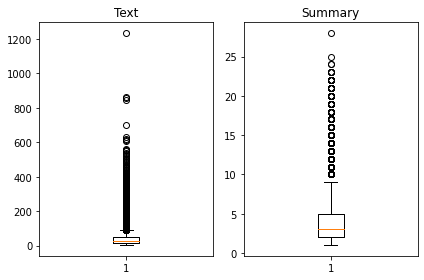

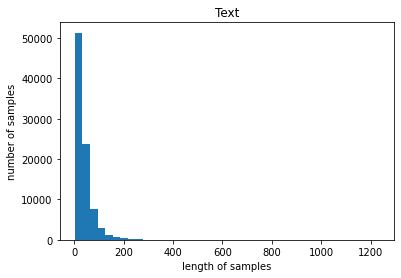

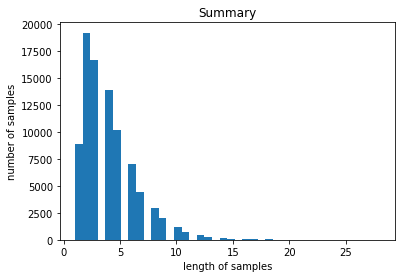

In [21]:
plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

# 'Text'컬럼 내 문장의 단어 개수 분포
plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

# 'Summary'컬럼 내 문장의 단어 개수 분포
plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [22]:
# Text의 최대길이와 Summary의 적절한 최대길이를 임의로 정해본다
text_max_len = 50
summary_max_len = 8

In [23]:
# 임의로 정한 최대 길이가 몇%의 샘플까지 포함하는지 볼 수 있다.
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt/len(nested_list))))

In [24]:
below_threshold_len(text_max_len, data['Text']) # 길이 50으로 패딩할 경우 이보다 긴 23%의 샘플들의 내용이 망가짐
below_threshold_len(summary_max_len, data['Summary']) # 길이 8으로 패딩할 경우 이보다 긴 6%의 샘플들의 내용이 망가짐

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.7745119121724859
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9424593967517402


In [25]:
# 정해진 길이보자 길면 제외하는 방법으로 데이터 정제해본다
data = data[data.apply(lambda row: len(row['Text']) <= text_max_len or len(row['Summary']) <= summary_max_len, axis=1)]


#잘 처리되었는지 확인
data.head()
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len, data['Summary'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9083905013192612
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9955672823218997


In [26]:
data.shape

(9475, 2)

### 시작 토큰과 종료 토큰 추가하기
- 디코더는 시작토큰 입력받아 문장 생성, 종료토큰을 예측한 순간 문장생성 멈춘다
- seq2seq훈련 위해 디코더 입력과 레이블에 시작토큰(`sostoken`)과 종료토큰(`eostoken`)을 추가한다
- `decoder_input` : 디코더의 입력, 시작토큰이 맨 앞에 있는 문장. summary 열로부터 만든다
- `decoder_target` : 디코더의 출력 or 레이블. 종료 토큰이 맨 뒤에 붙는 문장. summary 열로부터 만든다



In [103]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x: x + ' eostoken')
data.head() # 앞뒤로 토큰이 잘 붙은 걸 확인할 수 있다

,Summary,Text,decoder_input,decoder_target
17,love it,satisfied twizzler purchase shared others enjo...,sostoken love it,love it eostoken
23,twizzlers,love candy weight watchers cut back still craving,sostoken twizzlers,twizzlers eostoken
26,nasty no flavor,candy red flavor plan chewy would never buy,sostoken nasty no flavor,nasty no flavor eostoken
28,yummy,got mum diabetic needs watch sugar intake fath...,sostoken yummy,yummy eostoken
46,good,good oatmeal like apple cinnamon best though w...,sostoken good,good eostoken


In [59]:
# 인코더의 입력, 디코더의 입력과 레이블을 다시 Numpy 타입으로 저장
encoder_input = np.array(data['Text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

In [60]:
# 훈련데이터와 테스트 데이터 분리
# encoder_input과 크기와 형태 같은 순서가 섞인 정수 시퀀스 만든다

indices = np.arange(encoder_input.shape[0]) # 0~243까지 연속된 수의 배열 생성
np.random.shuffle(indices) # 배열 안 원소들을 섞는다
print(indices)

[1806 3837 7413 ... 9374 7146 6009]


In [61]:
# 이 시퀀스를 이용하여 다시 데이터 샘플 순서를 정의해 샘플을 섞어 준다
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [62]:
# 섞인 데이터를 8:2 비율로 훈련 / 테스트 데이터로 분리해준다.
# 전체 데이터의 크기에서 0.2 곱해 테스트 데이터 크기 정의한다

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수:', n_of_val)

테스트 데이터의 수: 1895


In [63]:
# 위에서 정의한 테스트 데이터 개수로 전체 데이터를 양분한다

encoder_input_train = encoder_input[:-n_of_val] # 배열의 처음부터, 끝에서부터 n_of_val 만큼 뺀 부분을 변수에 할당(0~0.8)
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:] # encoder_input의끝에서부터 n_of_val만큼 데이터 선택된다 (0,8~1.0)
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수:', len(encoder_input_train))
print('훈련 레이블의 개수:', len(decoder_input_train))
print('훈련 데이터의 개수:', len(encoder_input_test))
print('훈련 레이블의 개수:', len(decoder_input_test))

훈련 데이터의 개수: 7580
훈련 레이블의 개수: 7580
훈련 데이터의 개수: 1895
훈련 레이블의 개수: 1895


### 데이터 전처리하기 (3) 정수 인코딩
- 기계가 텍스트를 숫자로 처리할 수 있도록 훈련/테스트 데이터의 단어를 모두 정수로 바꿔준다
- 각 단어에 고유한 정수를 맵핑하는 작업을 `단어집합(vocabulary)`을 만든다고 한다
- keras의 Tokenizer() 메서드를 사용한다.
- src_tokenizer.`fit_on_text`(단어집합 생성할 대상) : 해당 문장들로부터 단어 집합 생성한다
- src_tokenizer.`word_index` : 생성된 단어집합 확인할 수 있다
- src_tokenizer.`word_counts.items()`: 단어와 각 단어의 등장 빈도수 저장되어있음

In [64]:
# keras의 토크나이저를 사용하여 훈련 데이터에 대해 단어집합을 만들어보자
# 우선 원문에 해당되는 encoder_input_train 에 대해 만든다

src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어집합 생성 & 각 단어에 고유한 정수 부여

In [65]:
# src_tokenizer.word_counts.items()

In [66]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


# 등장빈호가7회 미만인 단어들은 단어집합에서 70% 이상 차지
# 하지만 실제로 훈련데이터에서 차지하는 비중은 3.39%

단어 집합(vocabulary)의 크기 : 13172
등장 빈도가 6번 이하인 희귀 단어의 수: 10238
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2934
단어 집합에서 희귀 단어의 비율: 77.72547828727603
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 10.33535618492698


In [67]:
# 등장빈도가 6회 이하인 단어들을 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거한다
# 이를 제외한 단어집합을 8000여개로 계산했는데, 이와 비슷한 값으로 제한한다
# 토크나이저 정의시 num_words 값을 정의해주면 단어집합의 크기를 제한할 수 있다

src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [68]:
# text_to_sequences() : 정수 인코딩 메서드. 즉 생성된 단어집합에 기반, 입력으로 주어진 텍스트 데이터를 모두 정수로 변환
# 단어 집합의 크기를 8000으로 제한했으므로 8000이 넘는 숫자들은 인코딩후에 존재 X

encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train) # 텍스트 데이터가 아닌 정수로 출력되는 것을 확인할 수 있다

[[7038, 221, 75, 315, 16, 139, 73, 754, 691, 3731, 2352, 890, 210, 182, 496, 19, 1177, 402, 126, 754, 222, 7, 35], [5, 10, 234, 514, 239, 288, 333, 47, 246, 239, 1109, 5276, 1375, 7039, 202, 10, 283, 7040, 53, 1178, 592, 85, 10, 230], [2, 8, 195, 4330, 19, 7041, 243, 7042, 172, 3290, 3291, 4330, 104, 36, 839, 7, 137], [515, 284, 3732, 4, 236, 2718, 31, 809, 3, 8], [2077, 7043, 443, 1, 33, 2, 968, 236, 2, 183, 2, 148, 243, 991, 202, 16, 183, 99, 236, 6, 202, 2353, 66, 937, 182, 299, 26, 580, 48, 3292, 1289, 36, 1110, 51, 59, 109, 39, 1553, 479, 39, 3293, 80, 182, 191, 119, 1486, 891, 592, 1049, 147, 32, 21, 755, 454, 394, 32, 778, 2353, 70, 2935], [365, 2, 1050, 118, 1, 16, 65, 3294, 139, 365, 1696, 198, 2, 18], [5, 19, 49, 11, 3295, 1487, 1179, 264, 3733, 443, 1251, 1774, 196, 69], [428, 668, 275, 23, 20, 63, 4, 645], [3, 8, 1146, 1, 1958, 953, 280, 1072, 1434, 349, 8, 39, 3, 1435, 713, 84, 471, 27, 729, 756], [174, 8, 3734, 2936, 75, 624, 158, 19, 12, 840, 938, 44, 5277, 466, 361, 33,

In [69]:
# summary 데이터에 대해서도 동일한 작업을 수행한다
# 케라스의 토크나이저 사용해 decoder_input_train을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수 계산

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train) # 단어 집합 생성 & 고유 정수 부여 > tar_tokenizer.word_index 저장되어있음

In [70]:
# tar_tokenizer.word_index # 단어집합 & 각 단어에 부여된 고유한 정수
tar_tokenizer.word_counts.items() # 단어와 각 단어의 등장 빈도수

odict_items([('sostoken', 7580), ('mat', 1), ('great', 446), ('fi', 1), ('shock', 1), ('minty', 1), ('horrible', 40), ('good', 453), ('too', 55), ('cute', 9), ('hard', 12), ('to', 44), ('find', 9), ('but', 58), ('finally', 28), ('located', 1), ('online', 1), ('at', 10), ('decent', 15), ('price', 38), ('yummy', 605), ('not', 213), ('coffee', 90), ('yuck', 106), ('love', 428), ('it', 540), ('tasty', 180), ('yum', 478), ('pretty', 7), ('tip', 2), ('pure', 2), ('via', 1), ('tea', 159), ('am', 6), ('fan', 21), ('gift', 20), ('well', 13), ('received', 2), ('rip', 30), ('off', 31), ('is', 69), ('ok', 142), ('so', 186), ('product', 40), ('perfect', 99), ('its', 18), ('seed', 1), ('tastless', 1), ('this', 55), ('dressing', 3), ('indulge', 1), ('awesome', 226), ('meh', 38), ('terrible', 38), ('loved', 34), ('buy', 53), ('bland', 23), ('cheaper', 1), ('on', 18), ('petco', 1), ('site', 1), ('kudos', 1), ('gumman', 1), ('no', 72), ('like', 59), ('heaven', 10), ('arf', 1), ('ehh', 7), ('crisp', 2), 

In [71]:
# 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼 비중 차지하는지 확인해보자
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어 집합 내 단어의 총 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍을 key와 value로 받는다
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value
        
print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

# 등장빈도 5회 이하인 단어 : 77%
# 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중 : 5.87%

단어 집합(vocabulary)의 크기 : 2000
등장 빈도가 5번 이하인 희귀 단어의 수: 1751
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 249
단어 집합에서 희귀 단어의 비율: 87.55
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 13.647847383346223


In [72]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train) # 단어 고유 집합 & 정수 부여

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 760], [1, 7], [1, 761, 762], [1, 763], [1, 43]]
target
decoder  [[760, 2], [7, 2], [761, 762, 2], [763, 2], [43, 2]]


In [73]:
# 현재 decoder_input_train 과 decoder_target_train 에는 더이상 2000이 넘는 숫자들은 존재 X
# 패딩 작업으로 넘어가기 전에 빈도수 낮은 단어들로만 구성되어있었던 샘플들이 다 잘려나가 비어 Null값이 되지 않았는지 확인한다
# 요약문에서 길이가 0이 된 샘플들의 인덱스를 받아온다
# 이때 decoder_input에는 sostoken, decoder_target에는 eostoken이 추가된 상태
# 두 토큰은 모든 샘플에 등장하므로 빈도수가 매우 높음. 단어 집합 제한에서도 삭제 X
# 그러므로 길이가 0이 된 요약문 실제 길이는 1로 나옴.

# 훈련/테스트 데이터에 대해 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 저장해본다. 해당샘플들은 삭제될 예정이다


drop_train = [ index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1 ]
drop_test = [ index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1 ]

print('삭제할 훈련 데이터의 개수:', len(drop_train))
print('삭제할 테스트 데이터의 개수:', len(drop_test))

# 인덱스가 위 drop_train, drop_test에 해당하지 않는 원소들만으로 다시 배열을 구성한다
encoder_input_train = [ sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train ]
decoder_input_train = [ sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train ]
decoder_target_train = [ sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train ]

encoder_input_test = [ sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_test ]
decoder_input_test = [ sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_test ]
decoder_target_test = [ sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_test ]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

# 훈련 데이터와 테스트 데이터 모두 일정량 샘플들이 제거된 것을 확인할 수 있다

삭제할 훈련 데이터의 개수: 2
삭제할 테스트 데이터의 개수: 147
훈련 데이터의 개수 : 7578
훈련 레이블의 개수 : 7578
테스트 데이터의 개수 : 7431
테스트 레이블의 개수 : 7431


### 패딩하기
- **패딩작업** : 서로 다른 길이의 샘플들을 병렬처리하기위해 같은 길이로 맞춰주는 작업
- 패딩 길이는 아까 정해주었던 최대 길이로 한다.
- 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 맞춰준다

In [74]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

### 모델 설계하기
함수형 API를 이용해 인코더를 설계해보자

In [75]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Q.인코더 LSTM 1을 참고해서 나머지 인코더의 LSTM 2, LSTM 3의 코드를 완성하세요.

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)  # encoder_output1은 LSTM 1의 출력

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output3, state_h3, state_c3 = encoder_lstm3(encoder_output2)  # encoder_output2는 LSTM 2의 출력

In [76]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h3, state_c3])

In [77]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 50, 128)      1024000     input_6[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 50, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 어텐션 메커니즘

In [78]:
# 인코더의 hidden state들과 디코더의 hidden state들을 어텐션함수의 입력으로 사용하고
# 어텐션함수가 리턴한 값을 예측시에 디코더의 hidden state와 함께 활용

from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_output2])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 50, 128)      1024000     input_6[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 50, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [79]:
# 모델학습
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
30/30 [==============================] - 23s 532ms/step - loss: 2.0626 - val_loss: 1.4030
Epoch 2/50
30/30 [==============================] - 15s 505ms/step - loss: 1.3346 - val_loss: 1.2181
Epoch 3/50
30/30 [==============================] - 15s 494ms/step - loss: 1.1915 - val_loss: 1.1256
Epoch 4/50
30/30 [==============================] - 15s 510ms/step - loss: 1.1263 - val_loss: 1.0780
Epoch 5/50
30/30 [==============================] - 15s 489ms/step - loss: 1.0778 - val_loss: 1.0385
Epoch 6/50
30/30 [==============================] - 15s 494ms/step - loss: 1.0405 - val_loss: 1.0051
Epoch 7/50
30/30 [==============================] - 15s 497ms/step - loss: 1.0156 - val_loss: 0.9754
Epoch 8/50
30/30 [==============================] - 15s 507ms/step - loss: 0.9898 - val_loss: 0.9523
Epoch 9/50
30/30 [==============================] - 15s 493ms/step - loss: 0.9691 - val_loss: 0.9387
Epoch 10/50
30/30 [==============================] - 15s 492ms/step - loss: 0.9513 - val_lo

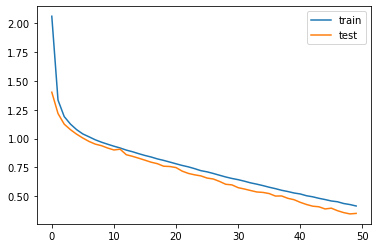

In [80]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 인퍼런스 모델 구현하기
테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 준비둔다

In [81]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

- seq2seqs는 훈련할 때와 실제 동작할 때(인퍼런스단계) 방식이 다르므로 그에 맞게 모델설계를 별도로 진행해야함
- 훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비

- 그러나 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 함. 이때는 인코더 모델과 디코더 모델을 분리해서 설계한다

In [82]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_output2, state_h3, state_c3])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [83]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [84]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [118]:
### 모델 테스트하기

# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp = ''
    for i in input_seq:
        if (i != 0 and i != tar_word_to_index['sostoken']):  # 시작 토큰(sostoken)을 만나면 종료
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [119]:
print(decoder_input_test[0])
print(decoder_input_test[1])
print(decoder_input_test[2])
print(decoder_input_test[2])
print(tar_index_to_word[3])

[  1 760   0   0   0   0   0   0]
[1 7 0 0 0 0 0 0]
[  1 761 762   0   0   0   0   0]
[  1 761 762   0   0   0   0   0]
yummy


In [120]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : always looking healthy versions regular food given hard find pure buckwheat products happy find product amazon com basically texture regular store bought pasta tastes great hope soon varieties pasta made available stick highly recommend anyone looking healthier versions regular stuff 
실제 요약 : like 
예측 요약 :  perfect


원문 : held biscuit one newman another brand strong aroma work newman advantage time sam went hand old familiar treat soon downed sniffing around newman still held front know tests prove anything skipped human taste test biscuits durable afraid would crack implant buy newman saw would get sam dog deserves good treat 
실제 요약 : arf 
예측 요약 :  arf


원문 : nice kit fermenation went well wine finished nice dry subtle anise charater suited patio white wine sure charaterisic appellation order new zealand kit next time keg rather bottle wine flexibility pouring one glass one liter mix nicely see lot sangrias summer 
실제 요약 : ehh 
예측 요약 :  ehh


원문 : love chips bought stock entire s

### 추출적 요약 해보기
- 이미 본문에 존재하는 단어, 구, 문장을 뽑아 요약
- Summa 패키지에서는 추출적 요약을 위한 모듈 `summarize` 제공하고 있다


In [121]:
# 데이터 다운로드
import requests
from summa.summarizer import summarize

In [122]:
# 매트릭스 시놉시스 다운받아 변수에 저장
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [123]:
# 매트릭스 시놉시스가 문자열로 저장되어있다. 일부 출력해보고 잘 저장되어있는지 확인
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

### Summarize 사용하기
- Summa의 Summarize는 문장토큰화를 별도로 하지 않아도 내부적으로 문장토큰화를 수행
- 문장 구분이 되어있지 않은 원문 넣어도 된다
---
- text (str) : 요약할 테스트.
- ratio (float, optional) – 요약문에서 원본이 선택되는 문장 비율. 0~1 사이값
- words (int or None, optional) – 출력에 포함할 단어 수.
    (만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.)
- split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

In [132]:
# 비율을 적게 주어 요약문으로 선택되는 문장의 개수를 줄여보자(원문의 0.005%)

print('Summary:')
print(summarize(text, ratio=0.005))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [126]:
# 리스트로 출력결과를 받으려면 split=True
print('Summary:')
print(summarize(text, ratio=0.005, split=True))

Summary:
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


In [128]:
# 단어의 수로 요약문의 크기를 조절할 수 있다
print('Summary:')
print(summarize(text, words=50))

Summary:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.
